In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-08-09 18:47:14.955600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 18:47:16.885146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-09 18:47:18.410167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.451779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.452048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2023-08-09 18:47:18.467209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Default GPU Device: /device:GPU:0


2023-08-09 18:47:18.467806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:18.468185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.274752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-08-09 18:47:19.301960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.302476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 18:47:19.302783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [6]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

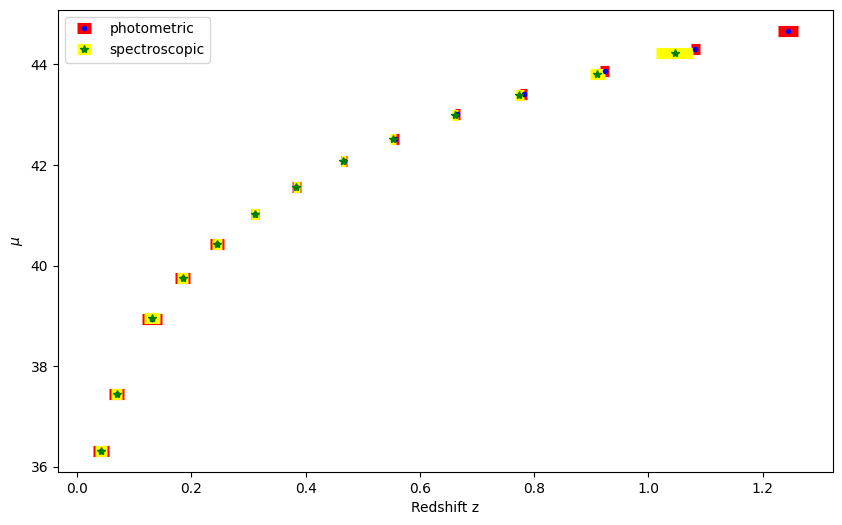

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [8]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [9]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [10]:
len(dfp)

14

In [11]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [12]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [13]:
np.shape(noise1y)

(14, 2)

In [14]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


In [15]:
np.shape(y), np.shape(z)

((42, 2), (42,))

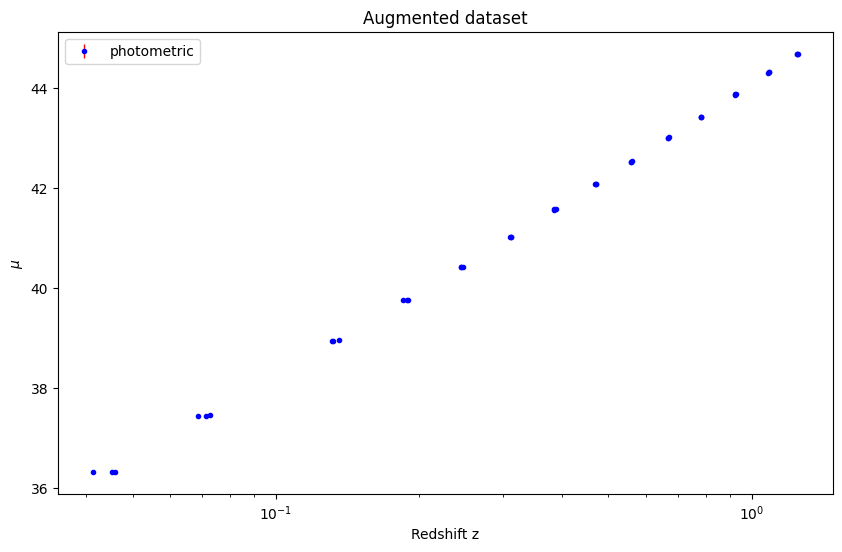

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [17]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z_sc = scalerz.transform(z.reshape(-1,1))
np.shape(z_sc)

(42, 1)

In [18]:
split = 0.9
ntrain = int(split * len(z))

randomize = np.random.permutation(len(z))
z = z_sc[randomize]
y = y[randomize]

indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(z_test), np.shape(y_train), np.shape(y_test)

((37, 1), (5, 1), (37, 2), (5, 2))

In [19]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [20]:
yy_train = np.append(y_train, np.array([y_or[0], y_or[-1]]), axis=0)
zz_train = np.append(z_train, np.array([z_sc[0], z_sc[-1]]))
np.shape(zz_train), np.shape(yy_train)

((39,), (39, 2))

In [27]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[3], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 8
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200,200,200,200])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               400       
                                                                 
 MCDropout_4 (MCDropout)     (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_5 (MCDropout)     (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_6 (MCDropout)     (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 200)              

In [28]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(zz_train, yy_train, batch_size=batch_size,
                                    epochs=1500, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/1500
5/5 [==============================] - 1s 64ms/step - loss: 854.9844 - val_loss: 885.6024
Epoch 2/1500
5/5 [==============================] - 0s 15ms/step - loss: 853.6439 - val_loss: 883.3995
Epoch 3/1500
5/5 [==============================] - 0s 16ms/step - loss: 851.8641 - val_loss: 882.2307
Epoch 4/1500
5/5 [==============================] - 0s 14ms/step - loss: 850.1374 - val_loss: 881.3913
Epoch 5/1500
5/5 [==============================] - 0s 17ms/step - loss: 847.9408 - val_loss: 879.6838
Epoch 6/1500
5/5 [==============================] - 0s 15ms/step - loss: 846.3818 - val_loss: 877.3429
Epoch 7/1500
5/5 [==============================] - 0s 14ms/step - loss: 844.0491 - val_loss: 874.6574
Epoch 8/1500
5/5 [==============================] - 0s 16ms/step - loss: 841.7197 - val_loss: 871.6077
Epoch 9/1500
5/5 [==============================] - 0s 15ms/step - loss: 839.2726 - val_loss: 869.6151
Epoch 10/1500
5/5 [==============================] - 0s 17ms/step - loss:

5/5 [==============================] - 0s 14ms/step - loss: 46.0120 - val_loss: 40.7849
Epoch 81/1500
5/5 [==============================] - 0s 13ms/step - loss: 45.3984 - val_loss: 36.9630
Epoch 82/1500
5/5 [==============================] - 0s 12ms/step - loss: 48.4389 - val_loss: 62.5972
Epoch 83/1500
5/5 [==============================] - 0s 13ms/step - loss: 39.1422 - val_loss: 39.4309
Epoch 84/1500
5/5 [==============================] - 0s 13ms/step - loss: 39.3818 - val_loss: 36.5640
Epoch 85/1500
5/5 [==============================] - 0s 13ms/step - loss: 39.0526 - val_loss: 31.3878
Epoch 86/1500
5/5 [==============================] - 0s 13ms/step - loss: 43.5516 - val_loss: 44.5637
Epoch 87/1500
5/5 [==============================] - 0s 15ms/step - loss: 36.2068 - val_loss: 35.7105
Epoch 88/1500
5/5 [==============================] - 0s 15ms/step - loss: 36.2300 - val_loss: 29.9179
Epoch 89/1500
5/5 [==============================] - 0s 14ms/step - loss: 34.9161 - val_loss: 40

5/5 [==============================] - 0s 12ms/step - loss: 6.4431 - val_loss: 7.3724
Epoch 161/1500
5/5 [==============================] - 0s 13ms/step - loss: 4.2815 - val_loss: 2.0354
Epoch 162/1500
5/5 [==============================] - 0s 14ms/step - loss: 5.0960 - val_loss: 2.4181
Epoch 163/1500
5/5 [==============================] - 0s 15ms/step - loss: 4.9031 - val_loss: 2.4081
Epoch 164/1500
5/5 [==============================] - 0s 14ms/step - loss: 4.8136 - val_loss: 1.8901
Epoch 165/1500
5/5 [==============================] - 0s 14ms/step - loss: 4.4206 - val_loss: 3.4487
Epoch 166/1500
5/5 [==============================] - 0s 15ms/step - loss: 5.9637 - val_loss: 6.5448
Epoch 167/1500
5/5 [==============================] - 0s 12ms/step - loss: 5.1980 - val_loss: 3.4109
Epoch 168/1500
5/5 [==============================] - 0s 12ms/step - loss: 6.0706 - val_loss: 10.8199
Epoch 169/1500
5/5 [==============================] - 0s 13ms/step - loss: 5.3985 - val_loss: 2.7415
Epoc

5/5 [==============================] - 0s 20ms/step - loss: 6.0007 - val_loss: 4.1252
Epoch 242/1500
5/5 [==============================] - 0s 20ms/step - loss: 6.1963 - val_loss: 1.7700
Epoch 243/1500
5/5 [==============================] - 0s 21ms/step - loss: 5.9000 - val_loss: 2.5294
Epoch 244/1500
5/5 [==============================] - 0s 22ms/step - loss: 4.2184 - val_loss: 3.1186
Epoch 245/1500
5/5 [==============================] - 0s 23ms/step - loss: 3.1137 - val_loss: 2.8212
Epoch 246/1500
5/5 [==============================] - 0s 23ms/step - loss: 4.3260 - val_loss: 2.3155
Epoch 247/1500
5/5 [==============================] - 0s 22ms/step - loss: 2.7487 - val_loss: 6.5920
Epoch 248/1500
5/5 [==============================] - 0s 20ms/step - loss: 5.1374 - val_loss: 9.0286
Epoch 249/1500
5/5 [==============================] - 0s 21ms/step - loss: 5.2231 - val_loss: 8.0139
Epoch 250/1500
5/5 [==============================] - 0s 21ms/step - loss: 5.0368 - val_loss: 5.7789
Epoch

5/5 [==============================] - 0s 17ms/step - loss: 5.1266 - val_loss: 4.0826
Epoch 323/1500
5/5 [==============================] - 0s 18ms/step - loss: 3.4374 - val_loss: 8.4037
Epoch 324/1500
5/5 [==============================] - 0s 18ms/step - loss: 5.7583 - val_loss: 1.0896
Epoch 325/1500
5/5 [==============================] - 0s 16ms/step - loss: 6.9282 - val_loss: 1.8691
Epoch 326/1500
5/5 [==============================] - 0s 16ms/step - loss: 4.5244 - val_loss: 3.7579
Epoch 327/1500
5/5 [==============================] - 0s 17ms/step - loss: 4.4669 - val_loss: 3.8974
Epoch 328/1500
5/5 [==============================] - 0s 17ms/step - loss: 5.2092 - val_loss: 3.9409
Epoch 329/1500
5/5 [==============================] - 0s 17ms/step - loss: 3.7654 - val_loss: 12.6482
Epoch 330/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.9091 - val_loss: 5.3542
Epoch 331/1500
5/5 [==============================] - 0s 18ms/step - loss: 6.1745 - val_loss: 6.0631
Epoc

5/5 [==============================] - 0s 19ms/step - loss: 5.2238 - val_loss: 1.2198
Epoch 404/1500
5/5 [==============================] - 0s 17ms/step - loss: 4.1893 - val_loss: 3.1727
Epoch 405/1500
5/5 [==============================] - 0s 18ms/step - loss: 4.7445 - val_loss: 2.4464
Epoch 406/1500
5/5 [==============================] - 0s 17ms/step - loss: 5.8343 - val_loss: 3.6342
Epoch 407/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.7361 - val_loss: 1.5236
Epoch 408/1500
5/5 [==============================] - 0s 18ms/step - loss: 4.1285 - val_loss: 1.0315
Epoch 409/1500
5/5 [==============================] - 0s 18ms/step - loss: 5.0644 - val_loss: 3.6515
Epoch 410/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.4091 - val_loss: 1.6602
Epoch 411/1500
5/5 [==============================] - 0s 16ms/step - loss: 5.4529 - val_loss: 2.7454
Epoch 412/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.1327 - val_loss: 4.6772
Epoch

5/5 [==============================] - 0s 15ms/step - loss: 4.8407 - val_loss: 2.5428
Epoch 485/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.6644 - val_loss: 5.4140
Epoch 486/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.4633 - val_loss: 5.0757
Epoch 487/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.9244 - val_loss: 3.0290
Epoch 488/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.1084 - val_loss: 2.1972
Epoch 489/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.8780 - val_loss: 5.4040
Epoch 490/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.2832 - val_loss: 4.5662
Epoch 491/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.2215 - val_loss: 5.3085
Epoch 492/1500
5/5 [==============================] - 0s 15ms/step - loss: 4.2085 - val_loss: 4.4003
Epoch 493/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.7574 - val_loss: 2.3488
Epoch

5/5 [==============================] - 0s 16ms/step - loss: 4.2014 - val_loss: 1.1414
Epoch 566/1500
5/5 [==============================] - 0s 11ms/step - loss: 2.4845 - val_loss: 5.5833
Epoch 567/1500
5/5 [==============================] - 0s 11ms/step - loss: 3.6420 - val_loss: 7.5465
Epoch 568/1500
5/5 [==============================] - 0s 8ms/step - loss: 4.6223 - val_loss: 10.9427
Epoch 569/1500
5/5 [==============================] - 0s 10ms/step - loss: 5.7211 - val_loss: 1.3540
Epoch 570/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.6351 - val_loss: 5.7651
Epoch 571/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.6691 - val_loss: 4.4266
Epoch 572/1500
5/5 [==============================] - 0s 19ms/step - loss: 5.1097 - val_loss: 2.5090
Epoch 573/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.6865 - val_loss: 4.1797
Epoch 574/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.7028 - val_loss: 6.0909
Epoch

5/5 [==============================] - 0s 9ms/step - loss: 3.2861 - val_loss: 3.1003
Epoch 647/1500
5/5 [==============================] - 0s 9ms/step - loss: 4.0721 - val_loss: 1.5257
Epoch 648/1500
5/5 [==============================] - 0s 11ms/step - loss: 3.3163 - val_loss: 2.2981
Epoch 649/1500
5/5 [==============================] - 0s 11ms/step - loss: 5.3198 - val_loss: 11.4461
Epoch 650/1500
5/5 [==============================] - 0s 11ms/step - loss: 2.3962 - val_loss: 4.2213
Epoch 651/1500
5/5 [==============================] - 0s 10ms/step - loss: 4.7702 - val_loss: 4.7466
Epoch 652/1500
5/5 [==============================] - 0s 11ms/step - loss: 2.8157 - val_loss: 1.7209
Epoch 653/1500
5/5 [==============================] - 0s 10ms/step - loss: 3.9289 - val_loss: 2.0017
Epoch 654/1500
5/5 [==============================] - 0s 11ms/step - loss: 4.3559 - val_loss: 3.1567
Epoch 655/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.5787 - val_loss: 2.8828
Epoch 

5/5 [==============================] - 0s 10ms/step - loss: 2.4454 - val_loss: 1.5331
Epoch 728/1500
5/5 [==============================] - 0s 10ms/step - loss: 3.9789 - val_loss: 7.0599
Epoch 729/1500
5/5 [==============================] - 0s 12ms/step - loss: 3.5242 - val_loss: 0.9501
Epoch 730/1500
5/5 [==============================] - 0s 10ms/step - loss: 3.0679 - val_loss: 3.7712
Epoch 731/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.8504 - val_loss: 3.5564
Epoch 732/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.6531 - val_loss: 0.9558
Epoch 733/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.4785 - val_loss: 1.1107
Epoch 734/1500
5/5 [==============================] - 0s 10ms/step - loss: 4.3656 - val_loss: 9.0038
Epoch 735/1500
5/5 [==============================] - 0s 13ms/step - loss: 5.2546 - val_loss: 2.4494
Epoch 736/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.9042 - val_loss: 1.8493
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 3.7351 - val_loss: 5.5362
Epoch 809/1500
5/5 [==============================] - 0s 12ms/step - loss: 3.4379 - val_loss: 0.5847
Epoch 810/1500
5/5 [==============================] - 0s 15ms/step - loss: 2.8726 - val_loss: 3.2943
Epoch 811/1500
5/5 [==============================] - 0s 14ms/step - loss: 4.1677 - val_loss: 2.4821
Epoch 812/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.9148 - val_loss: 2.5675
Epoch 813/1500
5/5 [==============================] - 0s 12ms/step - loss: 5.1517 - val_loss: 5.4823
Epoch 814/1500
5/5 [==============================] - 0s 14ms/step - loss: 4.1841 - val_loss: 11.9714
Epoch 815/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.6298 - val_loss: 3.8910
Epoch 816/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.7613 - val_loss: 6.0065
Epoch 817/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.9289 - val_loss: 7.1581
Epoc

5/5 [==============================] - 0s 14ms/step - loss: 3.9204 - val_loss: 5.3841
Epoch 890/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.2491 - val_loss: 1.9047
Epoch 891/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.6324 - val_loss: 3.0886
Epoch 892/1500
5/5 [==============================] - 0s 14ms/step - loss: 4.7637 - val_loss: 5.1665
Epoch 893/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.2858 - val_loss: 3.5090
Epoch 894/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.1245 - val_loss: 6.9868
Epoch 895/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.4955 - val_loss: 2.5803
Epoch 896/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.5575 - val_loss: 9.8740
Epoch 897/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.0261 - val_loss: 4.3876
Epoch 898/1500
5/5 [==============================] - 0s 15ms/step - loss: 3.2114 - val_loss: 2.8807
Epoch

5/5 [==============================] - 0s 13ms/step - loss: 2.7254 - val_loss: 4.9305
Epoch 971/1500
5/5 [==============================] - 0s 6ms/step - loss: 3.8535 - val_loss: 3.8828
Epoch 972/1500
5/5 [==============================] - 0s 8ms/step - loss: 2.7039 - val_loss: 4.5557
Epoch 973/1500
5/5 [==============================] - 0s 6ms/step - loss: 2.5306 - val_loss: 7.4835
Epoch 974/1500
5/5 [==============================] - 0s 9ms/step - loss: 3.0337 - val_loss: 6.9666
Epoch 975/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.8108 - val_loss: 6.7255
Epoch 976/1500
5/5 [==============================] - 0s 9ms/step - loss: 2.0310 - val_loss: 1.2199
Epoch 977/1500
5/5 [==============================] - 0s 11ms/step - loss: 4.0295 - val_loss: 1.7967
Epoch 978/1500
5/5 [==============================] - 0s 11ms/step - loss: 2.7780 - val_loss: 5.6944
Epoch 979/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.3422 - val_loss: 2.7047
Epoch 980/

5/5 [==============================] - 0s 8ms/step - loss: 3.2530 - val_loss: 1.4835
Epoch 1052/1500
5/5 [==============================] - 0s 13ms/step - loss: 2.8633 - val_loss: 1.4378
Epoch 1053/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.6068 - val_loss: 1.8638
Epoch 1054/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.5196 - val_loss: 2.2277
Epoch 1055/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.4908 - val_loss: 3.0538
Epoch 1056/1500
5/5 [==============================] - 0s 14ms/step - loss: 3.0705 - val_loss: 1.5885
Epoch 1057/1500
5/5 [==============================] - 0s 12ms/step - loss: 2.9448 - val_loss: 3.1462
Epoch 1058/1500
5/5 [==============================] - 0s 11ms/step - loss: 3.9290 - val_loss: 3.3333
Epoch 1059/1500
5/5 [==============================] - 0s 12ms/step - loss: 4.1630 - val_loss: 1.6990
Epoch 1060/1500
5/5 [==============================] - 0s 11ms/step - loss: 5.4206 - val_loss: 2.91

5/5 [==============================] - 0s 13ms/step - loss: 3.2306 - val_loss: 0.2707
Epoch 1132/1500
5/5 [==============================] - 0s 16ms/step - loss: 4.5021 - val_loss: 3.5166
Epoch 1133/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.7222 - val_loss: 5.1957
Epoch 1134/1500
5/5 [==============================] - 0s 16ms/step - loss: 2.5261 - val_loss: 2.3476
Epoch 1135/1500
5/5 [==============================] - 0s 13ms/step - loss: 4.3078 - val_loss: 4.1907
Epoch 1136/1500
5/5 [==============================] - 0s 16ms/step - loss: 2.5229 - val_loss: 7.8428
Epoch 1137/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.0156 - val_loss: 1.2719
Epoch 1138/1500
5/5 [==============================] - 0s 16ms/step - loss: 2.3797 - val_loss: 2.1929
Epoch 1139/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.9153 - val_loss: 1.8408
Epoch 1140/1500
5/5 [==============================] - 0s 16ms/step - loss: 2.3248 - val_loss: 3.7

5/5 [==============================] - 0s 11ms/step - loss: 3.2815 - val_loss: 1.6683
Epoch 1212/1500
5/5 [==============================] - 0s 14ms/step - loss: 2.8592 - val_loss: 1.6657
Epoch 1213/1500
5/5 [==============================] - 0s 13ms/step - loss: 4.4050 - val_loss: 3.0358
Epoch 1214/1500
5/5 [==============================] - 0s 12ms/step - loss: 4.6319 - val_loss: 3.5944
Epoch 1215/1500
5/5 [==============================] - 0s 13ms/step - loss: 3.2981 - val_loss: 1.6491
Epoch 1216/1500
5/5 [==============================] - 0s 11ms/step - loss: 2.5532 - val_loss: 2.4892
Epoch 1217/1500
5/5 [==============================] - 0s 13ms/step - loss: 2.4759 - val_loss: 3.4523
Epoch 1218/1500
5/5 [==============================] - 0s 10ms/step - loss: 2.6215 - val_loss: 3.9644
Epoch 1219/1500
5/5 [==============================] - 0s 12ms/step - loss: 3.3113 - val_loss: 3.6633
Epoch 1220/1500
5/5 [==============================] - 0s 11ms/step - loss: 3.4354 - val_loss: 4.9

5/5 [==============================] - 0s 18ms/step - loss: 3.4625 - val_loss: 4.5757
Epoch 1292/1500
5/5 [==============================] - 0s 16ms/step - loss: 3.8813 - val_loss: 6.8152
Epoch 1293/1500
5/5 [==============================] - 0s 17ms/step - loss: 3.3106 - val_loss: 4.1456
Epoch 1294/1500
5/5 [==============================] - 0s 18ms/step - loss: 3.7481 - val_loss: 3.3609
Epoch 1295/1500
5/5 [==============================] - 0s 17ms/step - loss: 4.0090 - val_loss: 2.2223
Epoch 1296/1500
5/5 [==============================] - 0s 17ms/step - loss: 2.8368 - val_loss: 2.1536
Epoch 1297/1500
5/5 [==============================] - 0s 18ms/step - loss: 2.2874 - val_loss: 2.1451
Epoch 1298/1500
5/5 [==============================] - 0s 17ms/step - loss: 4.0104 - val_loss: 2.7192
Epoch 1299/1500
5/5 [==============================] - 0s 18ms/step - loss: 2.8775 - val_loss: 1.1484
Epoch 1300/1500
5/5 [==============================] - 0s 18ms/step - loss: 3.0432 - val_loss: 3.0

In [29]:
model_train.history['val_loss'][-1]

5.934182167053223

(0.0, 200.0)

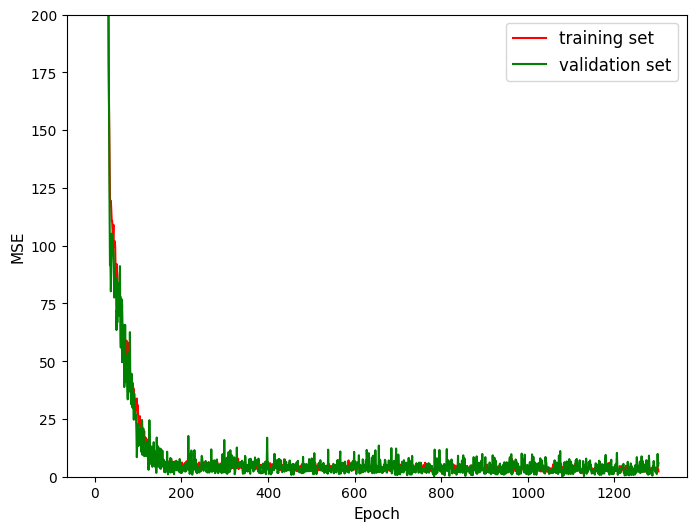

In [30]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [31]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 5ms/step


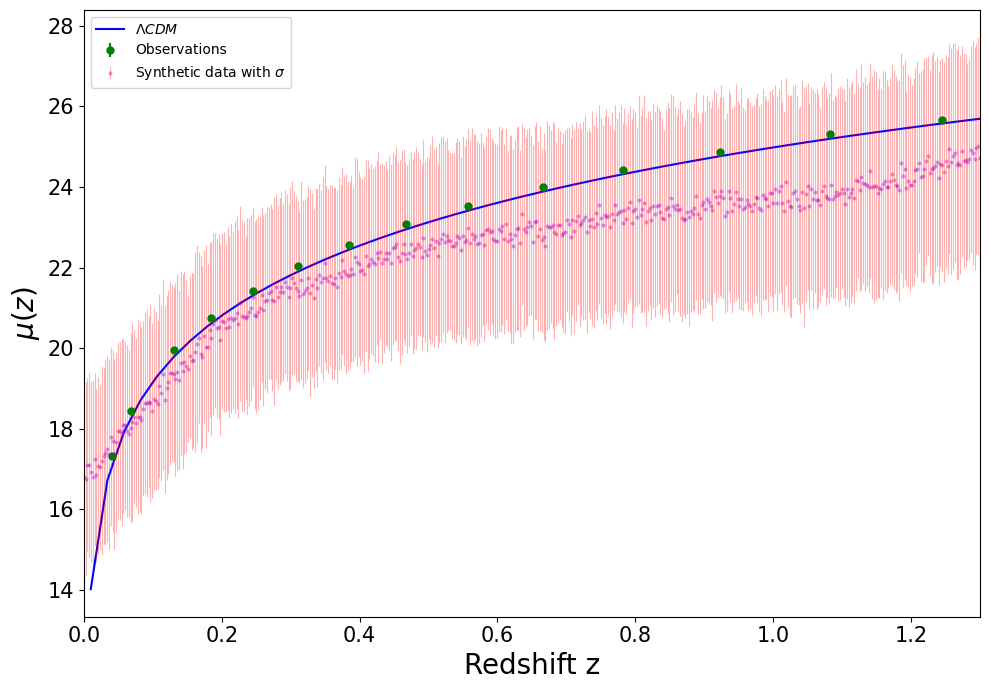

In [32]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors